Visualize the (kind-of) attention scores computed by the symmetric bilinear layer.

In [1]:
import tensorflow as tf
from BilinearSymmetric import SymmetricBilinearReduction
import sys
sys.path.append('../../learnMSA')
from learnMSA import msa_hmm
import os
import numpy as np
import seaborn as sns

In [2]:
def masked_crossentropy(y_true, y_pred):
    mask = tf.reduce_any(tf.not_equal(y_true, 0), -1)
    y_true_masked = tf.boolean_mask(y_true, mask)
    y_pred_masked = tf.boolean_mask(y_pred, mask)
    cee = tf.keras.metrics.categorical_crossentropy(y_true_masked, y_pred_masked)
    return tf.reduce_mean(cee)
    
emb_dim = 2560
    
def make_model(reduced_dim = 256, dropout = 0.2):
    # input to the training pipeline are pairs of embeddings
    emb1 = tf.keras.layers.Input(shape=(None, emb_dim))
    emb2 = tf.keras.layers.Input(shape=(None, emb_dim))

    # outputs are homology probabilities 
    output = SymmetricBilinearReduction(reduced_dim,
                                        dropout, 
                                        use_attention_scores = True)(emb1, emb2)

    # construct a model and compile for a standard binary classification task
    model = tf.keras.models.Model(inputs=[emb1, emb2], outputs=output)

    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=1e-2,
        decay_steps=1000,
        decay_rate=0.9)

    model.compile(loss=masked_crossentropy, 
                  optimizer=tf.keras.optimizers.Adam(lr_schedule),
                  metrics=[tf.keras.metrics.CategoricalAccuracy()])
    
    return model

#load the layer
bilinear_symmetric_model = make_model(64, 0.2)
bilinear_symmetric_model.load_weights("esm/bilinear_form_model_pfam_attention/checkpoints");
bilinear_symmetric_layer = bilinear_symmetric_model.layers[-1]

In [21]:
#load embeddings
filename = "../data/homfam/refs/msb.ref" 
fasta_file = msa_hmm.fasta.Fasta(filename, aligned=True)
noext_path = os.path.splitext(fasta_file.filename)[0]
file_basename_noext = os.path.basename(noext_path)
dataset = os.path.basename(os.path.dirname(os.path.dirname(noext_path)))
embeddings_base_path = f"esm/homfam/{file_basename_noext}/"
embedding_cache = []
for i, seq_id in enumerate(fasta_file.seq_ids):
    emb = np.load(embeddings_base_path+f"{seq_id}.npy")
    reduced_emb = bilinear_symmetric_layer._reduce(emb, training=False) 
    embedding_cache.append(reduced_emb)

-----------------------WSYNTSTEAMTYDEASAYCQQR--YTHLVAIQNKEEIEYLNSILS----YSPSYYWIGIRKVN----NVWVWVGTQKPLTEEAKNWAP---GEPNNRQKDEDCVEIYIKREKDVGMWNDERCSKKKLALCYTA--
---------ALQTVCLKGTKVHMKCFLAFTQTKTFHEASEDCISR--GGTLSTPQTGSENDALYEYLRQSV-GNEAEIWLGLNDMAAE--GTWVDM-TGARIA--YKNWETEITAQPDG-GKTENCAVLSGA---ANGKWFDKRCRDQLPYICQFGIV


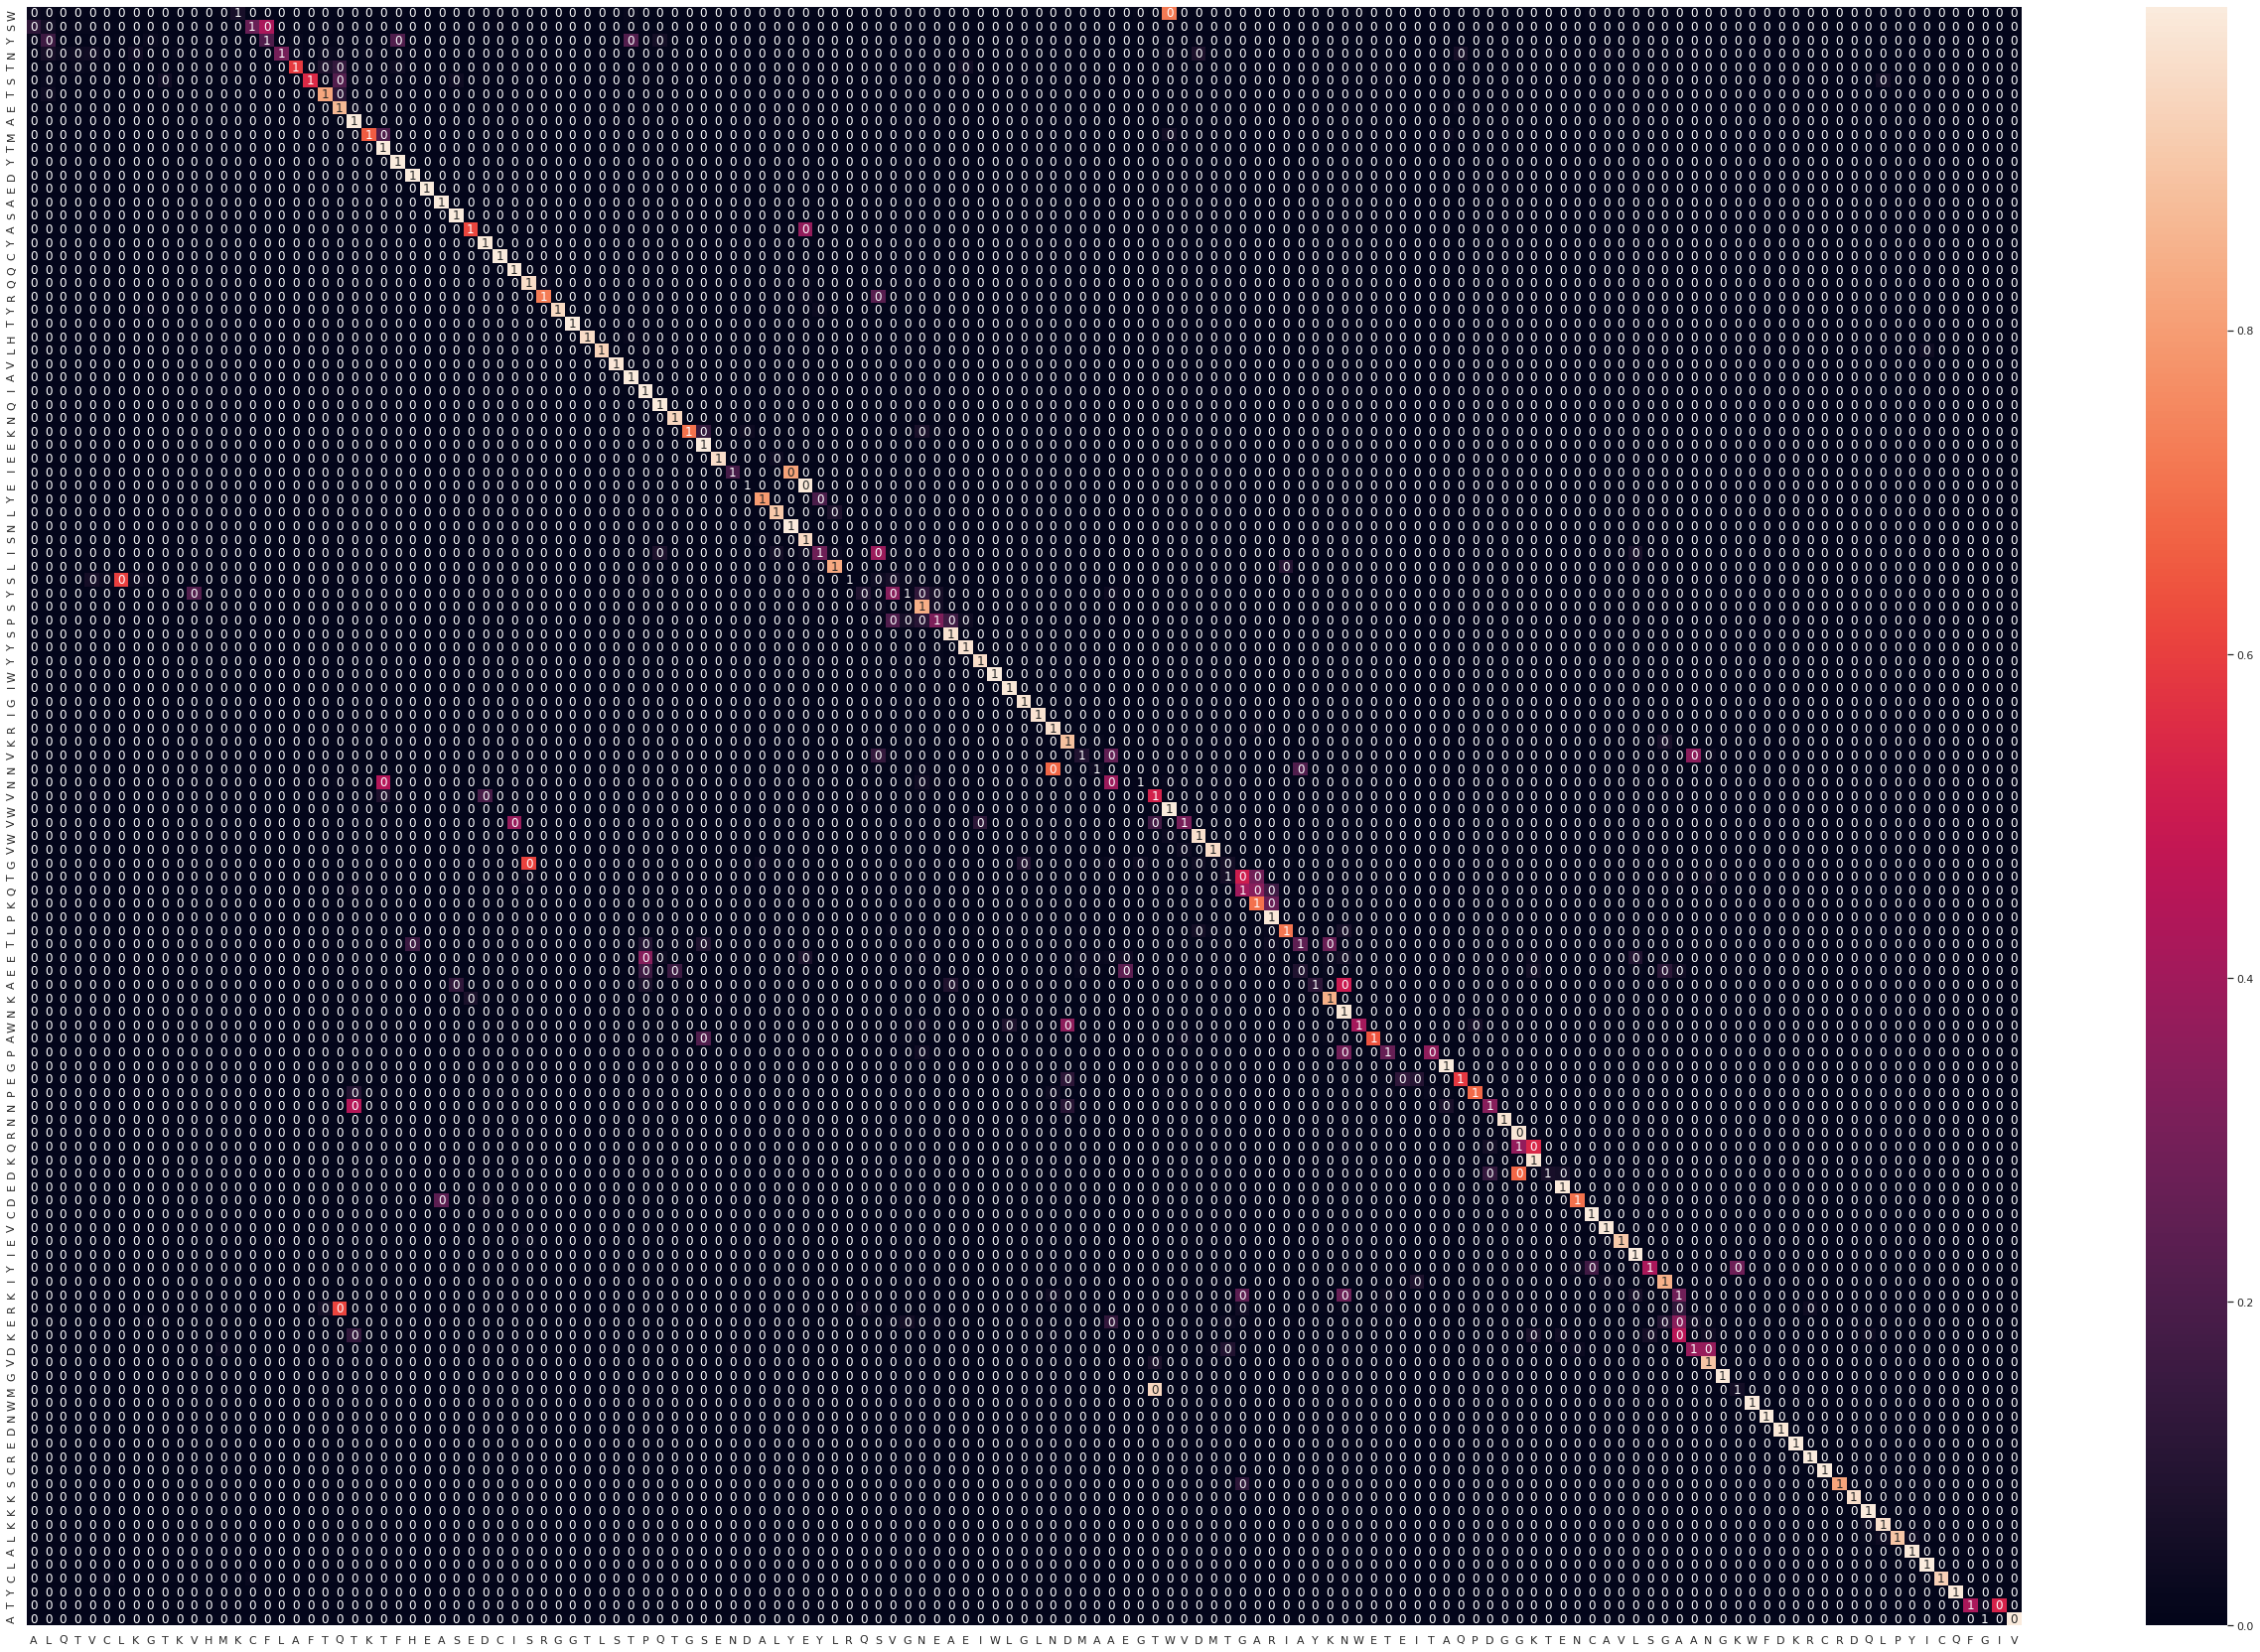

In [23]:
# plot the attention scores of a sequence pair i, j
i,j = 0, 3

seq_1 = fasta_file.column_str(i).replace("$", "-")
seq_2 = fasta_file.column_str(j).replace("$", "-")
print(seq_1)
print(seq_2)
attention_scores = bilinear_symmetric_layer(embedding_cache[i], embedding_cache[j], a_is_reduced=True, b_is_reduced=True, training=False)
cols_1 = fasta_file.membership_targets[fasta_file.starting_pos[i] : fasta_file.starting_pos[i] + fasta_file.seq_lens[i]]
cols_2 = fasta_file.membership_targets[fasta_file.starting_pos[j] : fasta_file.starting_pos[j] + fasta_file.seq_lens[j]]
ref_alignment = cols_1[:, np.newaxis] == cols_2[np.newaxis]
sns.set(rc={'figure.figsize':(45, 30)})
sns.heatmap(attention_scores, 
            annot=ref_alignment,
            xticklabels=seq_2.replace("-",""), 
            yticklabels=seq_1.replace("-",""));